In [13]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets
from torch import nn
from torch.optim import lr_scheduler

In [2]:
def plot_training_history(loss_values, accuracy_values):
    epochs = range(1, len(loss_values) + 1)
    
    _, ax1 = plt.subplots(figsize=(10, 6))
    
    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, loss_values, color=color, label='Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(epochs, accuracy_values, color=color, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title('Training Loss and Accuracy Over Time')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    
    plt.show()

In [23]:
def plot(x, ys, xlabel='x', ylabel='y', legend=None, title=None):
    """Plot multiple series on the same figure."""
    plt.figure(figsize=(6, 4))
    plt.plot(x, ys)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    if title:
        plt.title(title)
    plt.grid()
    plt.show()

In [3]:
def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

In [4]:
loss = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

batch_size = 256

train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=torchvision.transforms.ToTensor(),)
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=torchvision.transforms.ToTensor(),)

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [5]:

def train(model, train_dl, test_dl, num_epochs, criterion, optimizer, device, scheduler=None):
    model.to(device)
    loss_list, accuracy_list = [], []

    for epoch in tqdm(range(num_epochs), desc='Epoch:'):
        total_loss = 0
        accuracy = 0
        for i, (X, y) in enumerate(train_dl):
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = criterion(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        N = len(train_dl)
        total, correct = 0, 0
        for i, (X, y) in tqdm(enumerate(test_dl)):
            X, y = X.to(device), y.to(device)
            outputs= model(X)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
        accuracy = (100 * (correct / total))
        loss_list.append(total_loss/N)
        accuracy_list.append(accuracy)
        # wandb.log({"Train Loouss": total_loss/N, "Train Accuracy": accuracy})
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss  /N:.4f}, Accuracy: {accuracy:.2f}%")

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                scheduler.step()
            else:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = scheduler(epoch)
    
    plot_training_history(loss_list, accuracy_list)

40it [00:00, 41.15it/s]| 0/30 [00:00<?, ?it/s]
40it [00:00, 65.69it/s]| 1/30 [00:06<03:21,  6.93s/it]
40it [00:00, 96.31it/s]| 2/30 [00:14<03:19,  7.11s/it]
40it [00:00, 53.12it/s]| 3/30 [00:20<03:03,  6.78s/it]
40it [00:01, 38.80it/s]| 4/30 [00:27<02:57,  6.82s/it]
Epoch::  17%|█▋        | 5/30 [00:33<02:47,  6.69s/it]

Epoch [5/30] - Loss: 0.3354, Accuracy: 84.36%


40it [00:01, 39.61it/s]
40it [00:01, 37.80it/s]| 6/30 [00:41<02:47,  6.97s/it]
40it [00:01, 37.69it/s]| 7/30 [00:48<02:44,  7.13s/it]
40it [00:00, 62.52it/s]| 8/30 [00:56<02:40,  7.30s/it]
40it [00:01, 36.75it/s]| 9/30 [01:02<02:26,  6.99s/it]
Epoch::  33%|███▎      | 10/30 [01:09<02:17,  6.85s/it]

Epoch [10/30] - Loss: 0.2697, Accuracy: 87.95%


40it [00:01, 39.03it/s]
40it [00:01, 39.68it/s]| 11/30 [01:16<02:11,  6.94s/it]
40it [00:01, 39.42it/s]| 12/30 [01:24<02:07,  7.11s/it]
40it [00:00, 67.85it/s]| 13/30 [01:30<01:59,  7.02s/it]
40it [00:01, 38.60it/s]| 14/30 [01:37<01:48,  6.79s/it]
Epoch::  50%|█████     | 15/30 [01:43<01:39,  6.62s/it]

Epoch [15/30] - Loss: 0.2271, Accuracy: 89.11%


40it [00:01, 39.25it/s]
40it [00:01, 38.62it/s]| 16/30 [01:50<01:34,  6.76s/it]
40it [00:01, 39.59it/s]| 17/30 [01:57<01:30,  6.94s/it]
40it [00:00, 44.00it/s]| 18/30 [02:05<01:25,  7.09s/it]
40it [00:01, 37.18it/s]| 19/30 [02:12<01:17,  7.02s/it]
Epoch::  67%|██████▋   | 20/30 [02:19<01:11,  7.16s/it]

Epoch [20/30] - Loss: 0.1968, Accuracy: 89.01%


40it [00:00, 96.38it/s]
40it [00:01, 38.97it/s]| 21/30 [02:26<01:04,  7.14s/it]
40it [00:00, 40.16it/s]| 22/30 [02:33<00:57,  7.19s/it]
40it [00:00, 50.88it/s]| 23/30 [02:41<00:50,  7.27s/it]
40it [00:00, 42.78it/s]| 24/30 [02:47<00:42,  7.06s/it]
Epoch::  83%|████████▎ | 25/30 [02:54<00:35,  7.04s/it]

Epoch [25/30] - Loss: 0.1702, Accuracy: 88.40%


40it [00:01, 39.44it/s]
40it [00:01, 39.03it/s]| 26/30 [03:02<00:28,  7.08s/it]
40it [00:01, 39.70it/s]| 27/30 [03:08<00:20,  6.91s/it]
40it [00:01, 39.06it/s]| 28/30 [03:16<00:14,  7.10s/it]
40it [00:00, 40.20it/s]| 29/30 [03:23<00:07,  7.15s/it]
Epoch:: 100%|██████████| 30/30 [03:30<00:00,  7.01s/it]


Epoch [30/30] - Loss: 0.1484, Accuracy: 89.94%


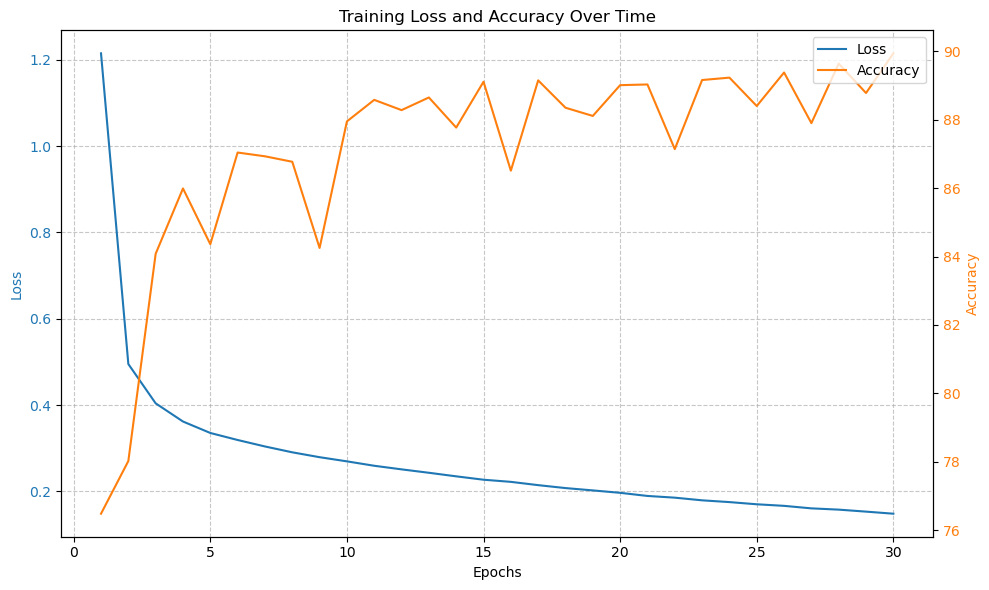

In [6]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
# wandb.init(project="fashion-mnist", name="training_run")
train(net, train_dl, test_dl, num_epochs, loss, trainer, device)
# wandb.finish()

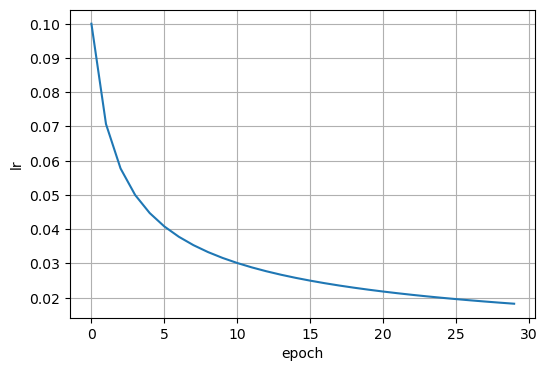

In [25]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr
    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

num_epochs = 30
scheduler = SquareRootScheduler(lr=0.1)
plot(np.arange(num_epochs), np.array([scheduler(t) for t in range(num_epochs)]),"epoch", "lr")


40it [00:00, 45.51it/s]| 0/30 [00:00<?, ?it/s]
40it [00:00, 45.05it/s]| 1/30 [00:06<02:58,  6.15s/it]
40it [00:00, 45.53it/s]| 2/30 [00:12<02:52,  6.17s/it]
40it [00:00, 45.92it/s]| 3/30 [00:17<02:30,  5.58s/it]
40it [00:00, 45.87it/s]| 4/30 [00:23<02:32,  5.87s/it]
Epoch::  17%|█▋        | 5/30 [00:30<02:32,  6.09s/it]

Epoch [5/30] - Loss: 0.3478, Accuracy: 81.57%


40it [00:00, 48.35it/s]
40it [00:00, 60.87it/s]| 6/30 [00:36<02:29,  6.23s/it]
40it [00:00, 45.29it/s]| 7/30 [00:42<02:23,  6.25s/it]
40it [00:00, 45.08it/s]| 8/30 [00:49<02:17,  6.26s/it]
40it [00:00, 46.11it/s]| 9/30 [00:55<02:11,  6.25s/it]
Epoch::  33%|███▎      | 10/30 [01:01<02:06,  6.32s/it]

Epoch [10/30] - Loss: 0.2734, Accuracy: 87.85%


40it [00:00, 44.36it/s]
40it [00:00, 57.16it/s]| 11/30 [01:08<02:00,  6.33s/it]
40it [00:00, 61.35it/s]| 12/30 [01:13<01:49,  6.10s/it]
40it [00:00, 45.38it/s]| 13/30 [01:19<01:43,  6.10s/it]
40it [00:00, 43.76it/s]| 14/30 [01:25<01:37,  6.10s/it]
Epoch::  50%|█████     | 15/30 [01:32<01:34,  6.27s/it]

Epoch [15/30] - Loss: 0.2334, Accuracy: 88.43%


40it [00:00, 45.46it/s]
40it [00:00, 107.50it/s] 16/30 [01:39<01:28,  6.32s/it]
40it [00:00, 43.50it/s]| 17/30 [01:44<01:19,  6.13s/it]
40it [00:00, 45.21it/s]| 18/30 [01:51<01:14,  6.22s/it]
40it [00:00, 47.99it/s]| 19/30 [01:57<01:10,  6.37s/it]
Epoch::  67%|██████▋   | 20/30 [02:02<00:59,  5.98s/it]

Epoch [20/30] - Loss: 0.2021, Accuracy: 89.01%


40it [00:00, 44.34it/s]
40it [00:00, 53.74it/s]| 21/30 [02:08<00:53,  5.98s/it]
40it [00:00, 44.52it/s]| 22/30 [02:14<00:46,  5.82s/it]
40it [00:00, 44.17it/s]| 23/30 [02:20<00:42,  6.02s/it]
40it [00:00, 44.45it/s]| 24/30 [02:27<00:37,  6.18s/it]
Epoch::  83%|████████▎ | 25/30 [02:34<00:31,  6.36s/it]

Epoch [25/30] - Loss: 0.1803, Accuracy: 87.93%


40it [00:00, 43.61it/s]
40it [00:00, 42.98it/s]| 26/30 [02:41<00:26,  6.50s/it]
40it [00:00, 40.53it/s]| 27/30 [02:47<00:19,  6.61s/it]
40it [00:00, 62.23it/s]| 28/30 [02:54<00:13,  6.50s/it]
40it [00:00, 48.82it/s]| 29/30 [03:00<00:06,  6.55s/it]
Epoch:: 100%|██████████| 30/30 [03:06<00:00,  6.23s/it]


Epoch [30/30] - Loss: 0.1589, Accuracy: 88.16%


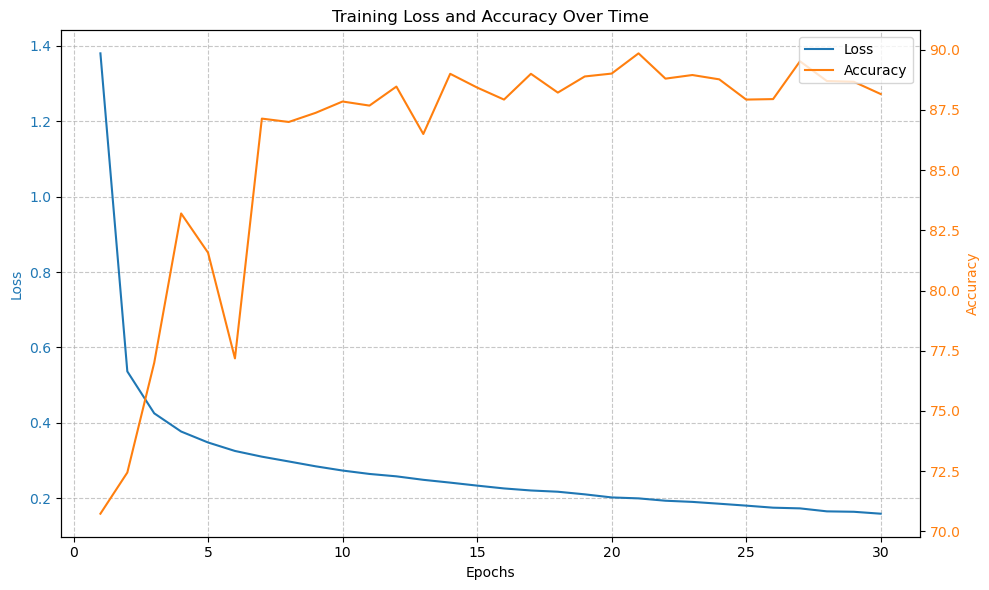

In [26]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_dl, test_dl, num_epochs, loss, trainer, device, scheduler)

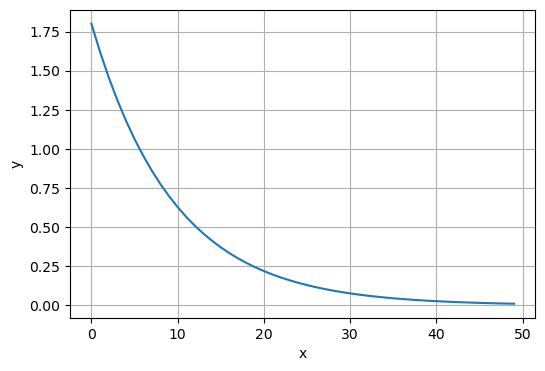

In [28]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
plot(torch.arange(50), [scheduler(t) for t in range(50)])

40it [00:00, 45.59it/s]| 0/30 [00:00<?, ?it/s]
40it [00:00, 45.78it/s]| 1/30 [00:06<03:11,  6.62s/it]
40it [00:00, 53.87it/s]| 2/30 [00:13<03:04,  6.57s/it]
40it [00:00, 45.49it/s]| 3/30 [00:19<02:54,  6.48s/it]
40it [00:00, 44.57it/s]| 4/30 [00:25<02:44,  6.31s/it]
Epoch::  17%|█▋        | 5/30 [00:32<02:39,  6.38s/it]

Epoch [5/30] - Loss: 0.3522, Accuracy: 86.29%


40it [00:00, 43.44it/s]
40it [00:00, 104.25it/s] 6/30 [00:38<02:29,  6.24s/it]
40it [00:00, 67.11it/s]| 7/30 [00:44<02:22,  6.18s/it]
40it [00:00, 62.08it/s]| 8/30 [00:48<02:04,  5.65s/it]
40it [00:00, 71.97it/s]| 9/30 [00:55<02:04,  5.91s/it]
Epoch::  33%|███▎      | 10/30 [01:01<02:01,  6.06s/it]

Epoch [10/30] - Loss: 0.2781, Accuracy: 85.03%


40it [00:00, 43.24it/s]
40it [00:00, 44.08it/s]| 11/30 [01:08<01:59,  6.28s/it]
40it [00:00, 58.16it/s]| 12/30 [01:14<01:54,  6.35s/it]
40it [00:00, 44.98it/s]| 13/30 [01:21<01:48,  6.40s/it]
40it [00:00, 43.79it/s]| 14/30 [01:28<01:44,  6.53s/it]
Epoch::  50%|█████     | 15/30 [01:34<01:38,  6.59s/it]

Epoch [15/30] - Loss: 0.2350, Accuracy: 88.66%


40it [00:00, 45.48it/s]
40it [00:00, 67.81it/s]| 16/30 [01:41<01:32,  6.61s/it]
40it [00:00, 72.01it/s]| 17/30 [01:46<01:20,  6.21s/it]
40it [00:00, 50.24it/s]| 18/30 [01:52<01:13,  6.11s/it]
40it [00:00, 88.69it/s]| 19/30 [01:59<01:09,  6.28s/it]
Epoch::  67%|██████▋   | 20/30 [02:04<01:00,  6.08s/it]

Epoch [20/30] - Loss: 0.1999, Accuracy: 88.30%


40it [00:00, 43.84it/s]
40it [00:00, 44.33it/s]| 21/30 [02:11<00:55,  6.19s/it]
40it [00:00, 44.04it/s]| 22/30 [02:18<00:50,  6.36s/it]
40it [00:00, 56.08it/s]| 23/30 [02:24<00:43,  6.27s/it]
40it [00:00, 64.58it/s]| 24/30 [02:29<00:35,  5.93s/it]
Epoch::  83%|████████▎ | 25/30 [02:35<00:29,  5.86s/it]

Epoch [25/30] - Loss: 0.1779, Accuracy: 87.86%


40it [00:00, 102.40it/s]
40it [00:00, 75.08it/s]| 26/30 [02:39<00:22,  5.57s/it]
40it [00:00, 77.59it/s]| 27/30 [02:46<00:17,  5.84s/it]
40it [00:01, 37.38it/s]| 28/30 [02:51<00:11,  5.70s/it]
40it [00:00, 55.40it/s]| 29/30 [02:57<00:05,  5.84s/it]
Epoch:: 100%|██████████| 30/30 [03:02<00:00,  6.10s/it]


Epoch [30/30] - Loss: 0.1570, Accuracy: 87.90%


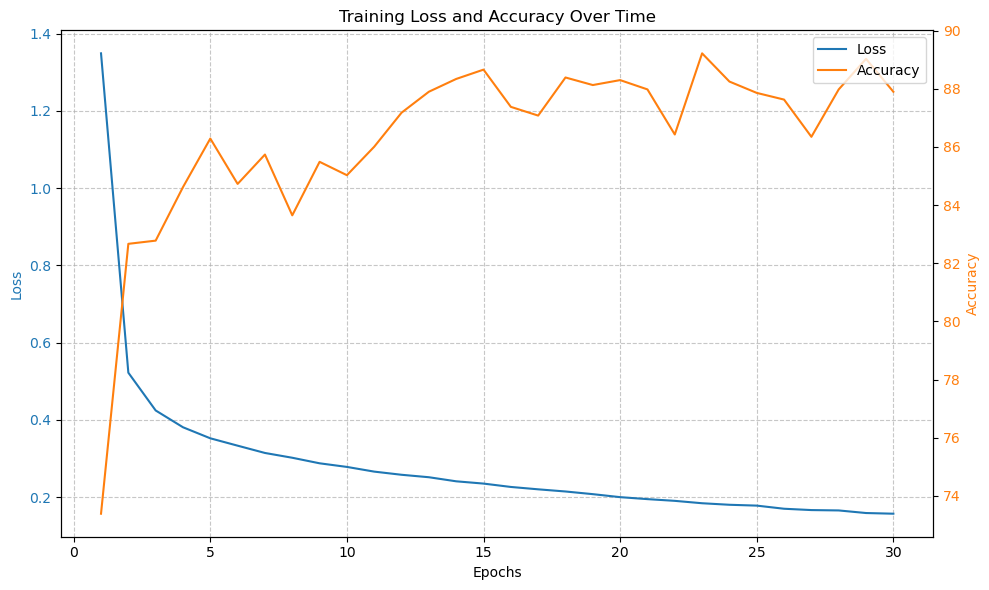

In [30]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_dl, test_dl, num_epochs, loss, trainer, device, scheduler)

40it [00:00, 64.89it/s]| 0/30 [00:00<?, ?it/s]
40it [00:00, 42.25it/s]| 1/30 [00:06<03:00,  6.24s/it]
40it [00:00, 45.09it/s]| 2/30 [00:11<02:45,  5.91s/it]
40it [00:00, 58.08it/s]| 3/30 [00:18<02:46,  6.16s/it]
40it [00:00, 52.27it/s]| 4/30 [00:24<02:42,  6.26s/it]
Epoch::  17%|█▋        | 5/30 [00:29<02:19,  5.59s/it]

Epoch [5/30] - Loss: 0.3497, Accuracy: 85.02%


40it [00:00, 53.27it/s]
40it [00:00, 81.06it/s]| 6/30 [00:35<02:21,  5.89s/it]
40it [00:00, 44.45it/s]| 7/30 [00:41<02:16,  5.94s/it]
40it [00:00, 44.66it/s]| 8/30 [00:48<02:13,  6.08s/it]
40it [00:00, 51.83it/s]| 9/30 [00:53<02:06,  6.02s/it]
Epoch::  33%|███▎      | 10/30 [01:00<02:04,  6.22s/it]

Epoch [10/30] - Loss: 0.2724, Accuracy: 87.23%


40it [00:00, 95.38it/s]
40it [00:00, 91.71it/s]| 11/30 [01:06<01:56,  6.12s/it]
40it [00:00, 44.28it/s]| 12/30 [01:11<01:46,  5.90s/it]
40it [00:00, 45.39it/s]| 13/30 [01:18<01:43,  6.07s/it]
40it [00:00, 42.31it/s]| 14/30 [01:24<01:37,  6.07s/it]
Epoch::  50%|█████     | 15/30 [01:31<01:34,  6.27s/it]

Epoch [15/30] - Loss: 0.2298, Accuracy: 88.44%


40it [00:00, 41.31it/s]
40it [00:00, 95.28it/s]| 16/30 [01:38<01:31,  6.51s/it]
40it [00:01, 39.69it/s]| 17/30 [01:43<01:21,  6.25s/it]
40it [00:01, 38.57it/s]| 18/30 [01:50<01:15,  6.26s/it]
40it [00:00, 43.41it/s]| 19/30 [01:57<01:12,  6.64s/it]
Epoch::  67%|██████▋   | 20/30 [02:05<01:08,  6.87s/it]

Epoch [20/30] - Loss: 0.1991, Accuracy: 86.60%


40it [00:00, 48.09it/s]
40it [00:01, 39.37it/s]| 21/30 [02:11<01:01,  6.79s/it]
40it [00:01, 39.17it/s]| 22/30 [02:19<00:55,  6.99s/it]
40it [00:01, 39.90it/s]| 23/30 [02:26<00:48,  6.98s/it]
40it [00:00, 111.42it/s] 24/30 [02:33<00:42,  7.06s/it]
Epoch::  83%|████████▎ | 25/30 [02:38<00:32,  6.51s/it]

Epoch [25/30] - Loss: 0.1751, Accuracy: 88.51%


40it [00:01, 39.64it/s]
40it [00:01, 39.20it/s]| 26/30 [02:43<00:23,  5.89s/it]
40it [00:01, 38.39it/s]| 27/30 [02:48<00:17,  5.79s/it]
40it [00:00, 67.32it/s]| 28/30 [02:55<00:12,  6.19s/it]
40it [00:00, 70.48it/s]| 29/30 [03:02<00:06,  6.37s/it]
Epoch:: 100%|██████████| 30/30 [03:08<00:00,  6.28s/it]


Epoch [30/30] - Loss: 0.1531, Accuracy: 88.37%


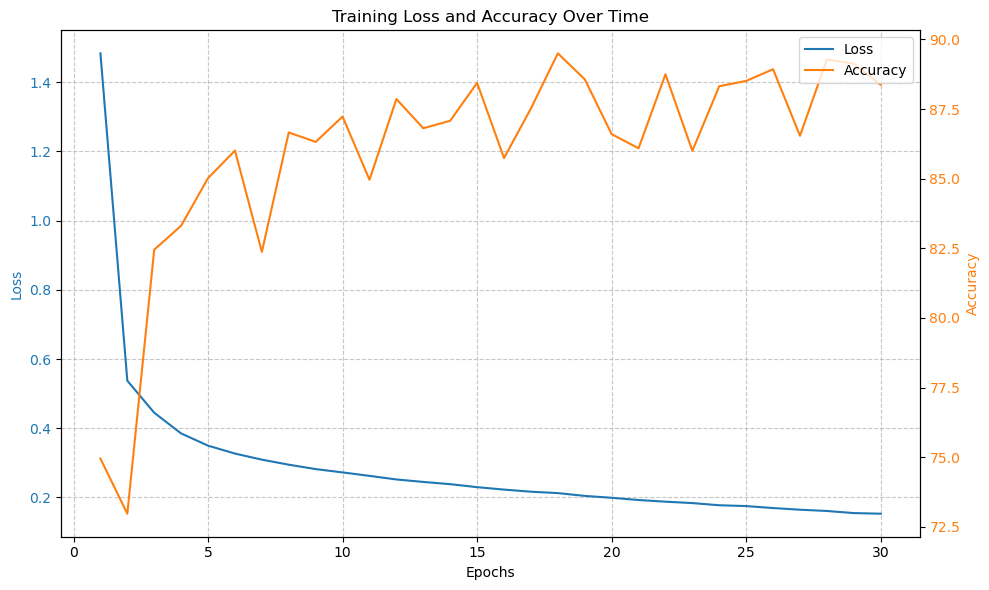

In [31]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(trainer, num_epochs)
train(net, train_dl, test_dl, num_epochs, loss, trainer, device, scheduler)